In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
#from tensorflow.python.ops import math_ops

%matplotlib inline

In [2]:
%run ./importWalkingDataConfidence.ipynb
tf.logging.set_verbosity(tf.logging.FATAL)

Dimension of walking test_x  =  (134, 27)
Dimension of walking train_x =  (536, 27)


In [3]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [4]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]


In [5]:
LABEL_ID = 0;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [6]:
# validation_metrics = {
#     "rmse":
#         tf.metrics.root_mean_squared_error(labels = pd.DataFrame(y_test[LABEL].values),predictions=y_predicted)
# }

In [7]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False),
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=200)
    #metrics=validation_metrics)

In [8]:
# Build 2 layer fully connected DNN with 100, 100 units respectively.
#model_dir_name="/DNN/quadMotionConfidenceSoftplus1Layer10UnitsEarlyStopLearnRate01"
#model_dir_name="/DNN/quadMotionConfidenceRELU10xUnitsDropout04EarlyStop"
model_dir_name="/DNN/quadMotionConfidenceSoftplus1Layer1000UnitsDropout01EarlyStop"

# regressor = tf.contrib.learn.DNNRegressor(
#   feature_columns=feature_cols, hidden_units=[1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
#     optimizer = tf.train.ProximalAdagradOptimizer(
#       learning_rate=0.1,
#       l1_regularization_strength=0.001), dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), activation_fn = tf.nn.softplus)

regressor = tf.contrib.learn.DNNRegressor(
  feature_columns=feature_cols, hidden_units=[1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001), dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), activation_fn = tf.nn.softplus)

#tf.contrib.layers.xavier_initializer(uniform=True) # this seems more useful for vision stuff where there is lot of fan_in and fan_out

In [9]:
# Train.
regressor.fit(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000

DNNRegressor(params={'activation_fn': <function softplus at 0x0000024C30A14950>, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x0000024C35B31240>, 'feature_columns': (_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='swingFtHeight', shape=(1,)

In [10]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

MSE (tensorflow): 15.338549


In [11]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

In [12]:
y_predicted

[28.861858,
 21.327105,
 26.469122,
 25.032038,
 28.292126,
 29.5138,
 19.391779,
 20.567177,
 30.976406,
 31.825533,
 22.959385,
 19.191425,
 23.408195,
 23.239237,
 22.477695,
 25.283499,
 25.541252,
 26.220711,
 22.537476,
 29.904709,
 20.755402,
 22.630585,
 26.372663,
 30.489325,
 25.660564,
 22.765284,
 26.172195,
 25.086998,
 20.012129,
 30.827745,
 20.370649,
 23.279781,
 25.991152,
 27.844721,
 31.471352,
 25.574478,
 25.176945,
 29.195339,
 30.315912,
 28.906019,
 31.703356,
 25.507919,
 19.729193,
 25.326851,
 26.351265,
 30.264471,
 26.657782,
 32.97728,
 21.006216,
 26.697685,
 27.324038,
 28.05464,
 27.096516,
 26.784538,
 23.09436,
 21.328634,
 23.043097,
 24.458748,
 25.258684,
 21.379934,
 24.691475,
 23.333391,
 23.605099,
 26.164387,
 24.635668,
 29.688858,
 29.429497,
 21.338509,
 27.514551,
 27.402504,
 23.945562,
 32.218834,
 29.909542,
 32.950859,
 26.331596,
 23.859539,
 24.48988,
 24.947168,
 35.270912,
 24.859962,
 25.505062,
 22.848881,
 27.016436,
 28.805096

In [13]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test_all_wts[WT_COL].values)
print('MSE WTD (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test_all_wts[WT_COL].values)
print('R2 WTD (sklearn): {0:f}'.format(r2_score_wtd))

MSE (sklearn): 19.516498
R2 (sklearn): 0.423885
MSE WTD (sklearn): 18.126410
R2 WTD (sklearn): 0.488622


In [14]:
y_hat = pd.DataFrame(y_predicted, columns=["predicted_happy"], index=y_test[LABEL].index) 
y_test[LABEL]

98     35.832882
533    16.727348
235    28.033790
421    20.039478
2      28.210167
99     35.585371
40     18.441178
582    16.088111
286    28.529206
460    31.292538
419    21.575115
659    17.318055
91     20.816252
608    23.223020
596    20.067772
268    23.641136
217    22.868579
404    24.233680
26     29.964168
529    31.373120
479    18.623427
385    22.334702
97     27.824177
68     33.166887
412    32.853904
233    27.445447
651    18.788214
433    15.144414
188    23.825188
378    29.318471
         ...    
401    15.575888
232    19.380119
297    19.368628
89     18.566313
573    24.923224
478    22.948523
201    35.578657
228    22.474830
41     38.202983
278    14.167721
11     28.570411
504    19.092069
607    21.746343
643    28.152482
598    25.520545
593    24.377806
29     24.281018
588    17.198043
269    13.787126
237    17.840304
480    19.767796
5      21.575611
427    32.222035
208    30.092540
393    22.759171
303    22.325669
163    23.700262
319    22.5560

In [15]:
y_hat

predicted_happy
98         28.861858
533        21.327105
235        26.469122
421        25.032038
2          28.292126
99         29.513800
40         19.391779
582        20.567177
286        30.976406
460        31.825533
419        22.959385
659        19.191425
91         23.408195
608        23.239237
596        22.477695
268        25.283499
217        25.541252
404        26.220711
26         22.537476
529        29.904709
479        20.755402
385        22.630585
97         26.372663
68         30.489325
412        25.660564
233        22.765284
651        26.172195
433        25.086998
188        20.012129
378        30.827745
..               ...
401        26.580273
232        27.231361
297        20.406288
89         23.225977
573        24.259232
478        20.941694
201        29.439508
228        28.670065
41         30.102358
278        22.487064
11         21.832855
504        20.811417
607        22.076044
643        28.403252
598        27.128834
593        20.942158
29         22.923267
588        24.494797
269        20.301117
237        18.052338
480        26.127422
5          21.417637
427        32.049503
208        30.035221
393        28.308876
303        20.838419
163        24.172924
319        23.730839
597        22.442038
541        25.716274

[134 rows x 1 columns]

In [16]:
y_all = pd.concat([y_hat, y_test[LABEL], y_test["happier_sigma"], y_test["gif_id"]], axis=1) #gif id is only for debugging

In [17]:
y_all_sorted = y_all.sort_values("happier_mu",ascending=[True])

In [18]:
y_all_sorted

predicted_happy  happier_mu  happier_sigma  gif_id
55         21.456367   12.063560       5.021100     118
269        20.301117   13.787126       5.274157    2121
278        22.487064   14.167721       5.515768    2160
65         23.531696   14.194782       5.442390    1202
104        22.746735   14.215905       5.380826    1361
491        23.333391   14.875958       5.575036     389
433        25.086998   15.144414       5.493521    2780
597        22.442038   15.147500       5.914717     717
401        26.580273   15.575888       5.455207    2655
582        20.567177   16.088111       5.706264     669
220        21.006216   16.673583       6.019981     192
533        21.327105   16.727348       5.789500     493
588        24.494797   17.198043       5.955683     694
503        27.636595   17.307625       5.949658     423
659        19.191425   17.318055       6.044900     948
237        18.052338   17.840304       6.128548    1978
40         19.391779   18.441178       3.592258    1116
89         23.225977   18.566313       6.081598     130
479        20.755402   18.623427       5.193378     361
375        23.043097   18.770371       6.523414    2578
651        26.172195   18.788214       4.917566     922
504        20.811417   19.092069       5.010983     426
561        21.379934   19.225744       6.590370     573
297        20.406288   19.368628       5.344301    2252
232        27.231361   19.380119       5.163268    1953
645        19.729193   19.428960       4.757468      91
399        23.094360   19.578080       5.124231     265
420        21.328634   19.607496       3.681642    2736
480        26.127422   19.767796       5.046422     364
471        25.574478   19.962046       3.724462     347
..               ...         ...            ...     ...
378        30.827745   29.318471       3.512212     259
507        27.844721   29.395832       7.171476     430
256        27.514551   29.439206       2.407164     206
441        28.906019   29.533864       3.436180    2811
35         31.746490   29.671036       2.310562    1094
19         29.909542   29.877500       2.286055    1046
26         22.537476   29.964168       2.187889    1062
208        30.035221   30.092540       2.418731     185
131        25.326851   30.544071       2.173157    1468
460        31.825533   31.292538       2.153930     313
529        29.904709   31.373120       2.131020     485
440        24.859962   31.374994       2.186625    2792
406        29.429497   32.156878       2.065765    2668
427        32.049503   32.222035       2.167078     276
412        25.660564   32.853904       2.238605    2695
388        27.096516   33.024580       2.309432     262
349        31.703356   33.066553       2.104151    2443
133        32.950859   33.132164       2.581719    1486
68         30.489325   33.166887       2.237961    1223
87         25.258684   33.577144       2.308363    1299
595        27.568810   33.731407       2.196092     710
258        35.270912   34.705092       2.442714    2084
456        30.315912   35.325198       2.304957      29
201        29.439508   35.578657       2.217631    1807
99         29.513800   35.585371       2.012107    1346
98         28.861858   35.832882       2.407094    1345
16         29.195339   36.438012       2.553544    1037
451        35.452965   37.494617       2.324155    2856
41         30.102358   38.202983       2.745923    1117
489        32.977280   38.770583       2.563895     387

[134 rows x 4 columns]

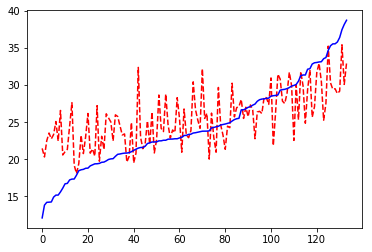

In [19]:
plt.figure()
plt.plot(y_all_sorted["predicted_happy"].values,'r--',y_all_sorted[LABEL].values,'b')

In [20]:
regressor.get_params()

{'params': {'activation_fn': <function tensorflow.python.ops.gen_nn_ops.softplus>,
  'dropout': 0.1,
  'embedding_lr_multipliers': None,
  'feature_columns': (_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.

In [21]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_train[LABEL].size))

MSE train (tensorflow): 20.533789


In [22]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train,sample_weight=X_train_all_wts[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train, sample_weight=X_train_all_wts[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 21.241063
R2 train (sklearn): 0.410940
MSE WTD train (sklearn): 19.586013
R2 WTD train (sklearn): 0.472062


Populating the interactive namespace from numpy and matplotlib


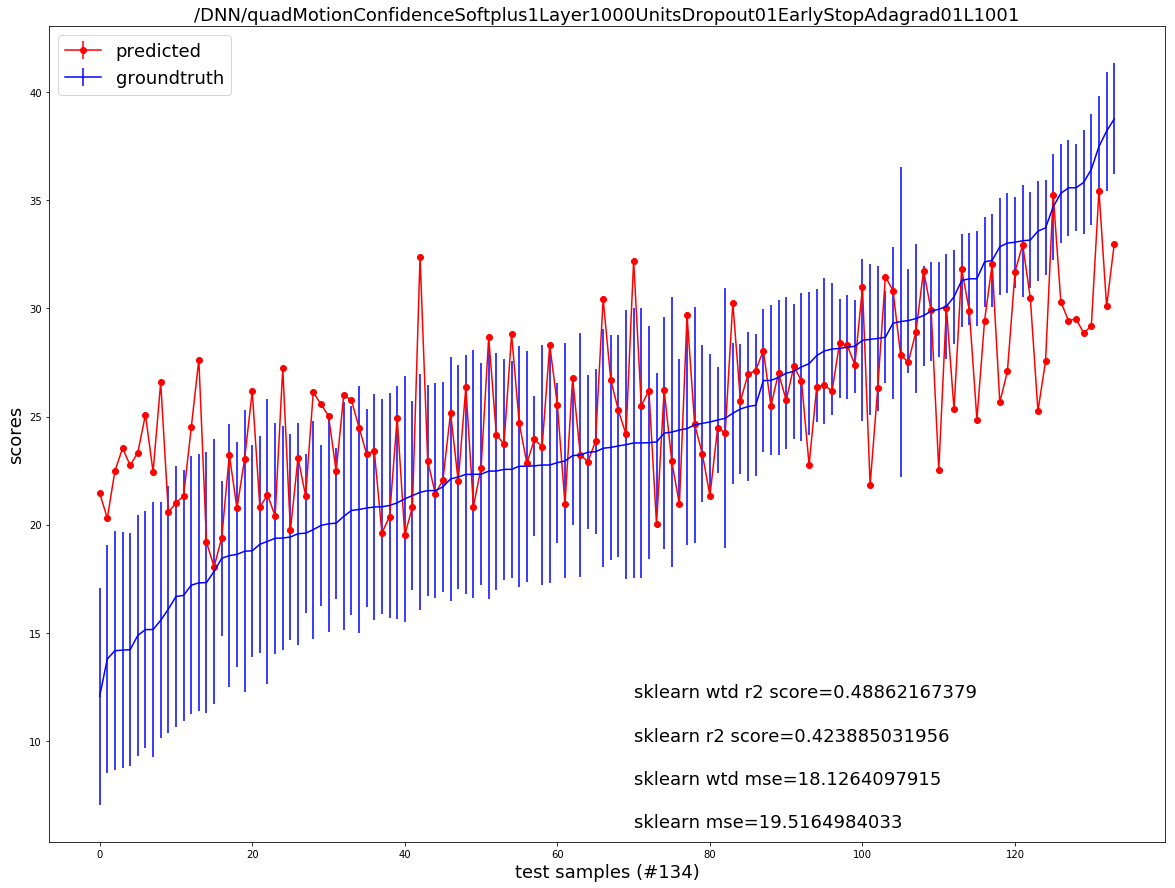

In [23]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted["predicted_happy"].size, 1)
plt.errorbar(x,y_all_sorted["predicted_happy"].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted[LABEL].values,yerr=y_all_sorted["happier_sigma"],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPrediction.pdf"
ax.savefig(fig_name) 

In [24]:
y_hat_train = pd.DataFrame(y_predicted_train, columns=["predicted_happy_train"], index=y_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_train[LABEL], y_train["happier_sigma"], y_train["gif_id"]], axis=1) #gif id is only for debugging
y_all_sorted_train = y_all_train.sort_values("happier_mu",ascending=[True])

Populating the interactive namespace from numpy and matplotlib


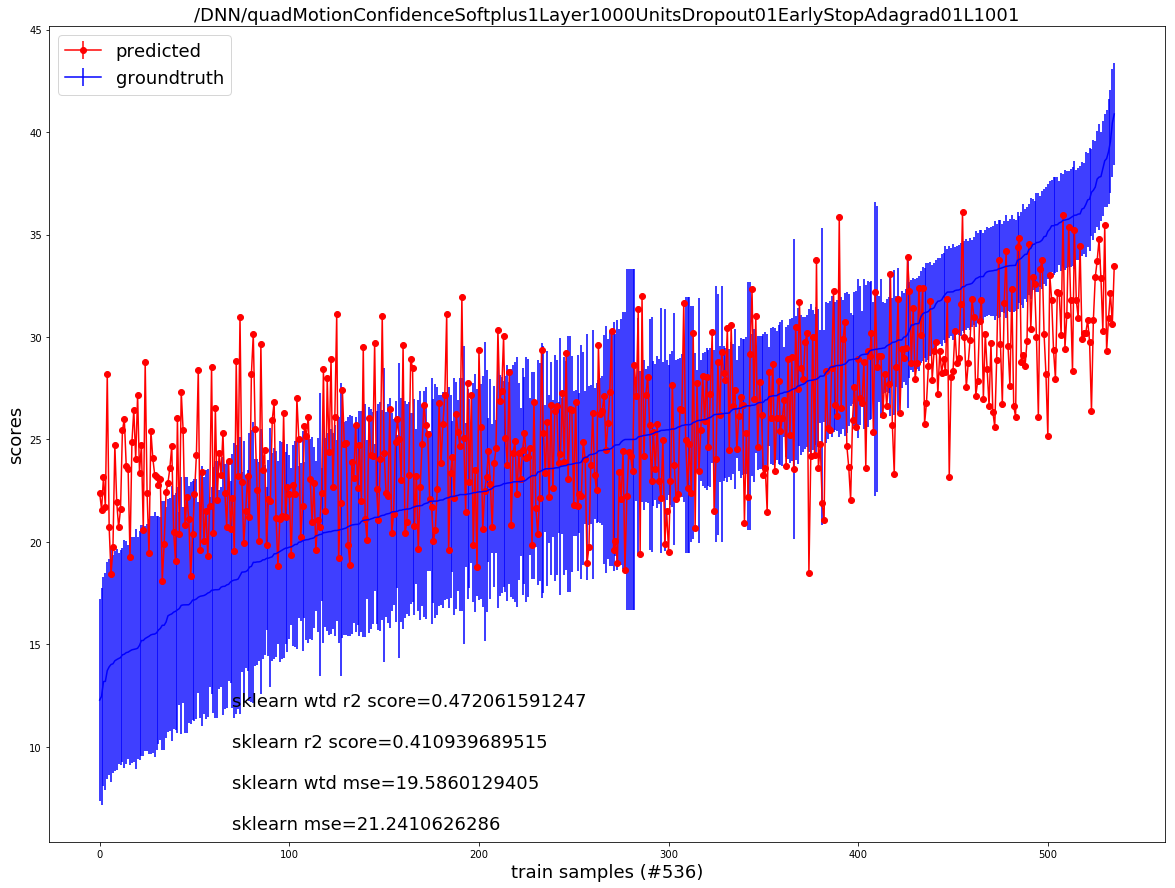

In [25]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train["predicted_happy_train"].size, 1)
plt.errorbar(x,y_all_sorted_train["predicted_happy_train"].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted_train[LABEL].values,yerr=y_all_sorted_train["happier_sigma"],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 

In [26]:
# y_true = y_all_sorted["happier_mu"].values
# y_predicted = y_all_sorted["predicted_happy"].values
# y_wts = (1.0-(y_all_sorted["happier_sigma"]/min_confidence)).values

# y_true = np.reshape(y_true,(134,1))
# y_predicted =np.reshape(y_predicted,(134,1))
# y_wts = np.reshape(y_wts,(134,1))

# sq_error = (y_true-y_predicted)**2
# wtd_sq_error = np.multiply(sq_error,y_wts)
# wtd_mse = np.mean(wtd_sq_error)
# mse = mean(sq_error)
# wtd_mse

In [27]:
# np.average((y_true - y_predicted)**2, axis =0,
#                                weights=y_wts)

In [28]:
# X_test_mean = X_test_all[FEATURES].mean()

In [29]:
# X_train_all["speed"].min()

# X_train_all["speed"].max()

# speed_range = np.arange(-1.9,2.2,0.1)

# # del X_speed_test
# # del mean_vals
# # del X_speed_test_df
# #X_speed_test=np.empty_like(X_test_mean.values)
# i = 0
# for s in speed_range:
#     #print('s=',s)
#     i= i+1
#     if(s==-1.9): 
#         mean_vals = np.copy(X_test_mean.values)
#         wt_vals = np.array([1,1,1]); # wts
#         mean_vals = np.append(mean_vals, 4) # ffp
#         mean_vals = np.append(mean_vals, wt_vals)
#         mean_vals[8] = s;
#         X_speed_test = mean_vals
#     else:
#     #elif(s>=-1.8 and s<=-1.7):
#         mean_vals2 = np.copy(X_test_mean.values)
#         wt_vals2 = np.array([1,1,1]);
#         mean_vals2 = np.append(mean_vals2, 4)
#         mean_vals2 = np.append(mean_vals2, wt_vals2)
#         mean_vals2[8] = s;
#         X_speed_test = np.append(X_speed_test, mean_vals2,axis=0)
# X_speed_test = X_speed_test.reshape(speed_range.size,len(FEATURESALL_WTS))
# X_speed_test_df = pd.DataFrame(X_speed_test, columns = FEATURESALL_WTS)
# # y_speed_test=np.empty_like(y_test.values)
# # y_speed_test = y_speed_test.reshape(y_test.shape)

# def get_input_fn_predict(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
#   return tf.estimator.inputs.pandas_input_fn(
#       x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
#       num_epochs=num_epochs,
#       shuffle=shuffle)

# X_speed_test_df["FFPType"] =X_speed_test_df["FFPType"].astype(int64)
# X_speed_test_df.dtypes

# predictions_speed_range = regressor.predict_scores(input_fn=get_input_fn_predict(X_speed_test_df, y_test, LABEL, num_epochs=1, shuffle=False))
# y_predicted_speed = list(itertools.islice(predictions_speed_range,X_speed_test_df["FFPType"].size))

# y_predicted_speed

# %pylab inline
# pylab.rcParams['figure.figsize'] = (20, 15)
# ax =plt.figure()
# x = speed_range
# plt.errorbar(x,y_predicted_speed,yerr=0,fmt='r-o',label="predicted")
# plt.title(model_dir_name +' happiness prediction wrt speed',fontsize=18)
# plt.xlabel('speed range',fontsize=18)
# plt.ylabel('scores',fontsize=18)
# fig_name = model_dir_name + "/happinessVsSpeedCurve.pdf"
# #ax.savefig(fig_name) 